# Import Dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os 
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import albumentations as A
import seaborn as sns
import io
import datetime
from sklearn.metrics import confusion_matrix, roc_curve

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, TensorBoard, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Input, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TrueNegatives, TruePositives, FalsePositives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import (
    Resizing, 
    Rescaling, 
    Layer,
    RandomRotation,
    RandomFlip, 
    RandomContrast,
    InputLayer,
    Conv2D,
    BatchNormalization,
    Dropout,
    MaxPool2D, 
    Flatten,
    Dense)

# Wandb Install, Login, Initialization and Configuration

In [2]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import wandb
from wandb.keras import WandbCallback

In [9]:
!wandb login

wandb: Currently logged in as: timothy-tandt. Use `wandb login --relogin` to force relogin


In [10]:
wandb.init(project="Malaria-Detection", entity='timothy-tandt')

wandb: Currently logged in as: timothy-tandt. Use `wandb login --relogin` to force relogin


In [3]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE":2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}

CONFIGURATION = wandb.config

# Data Preparation

## Data Loading

In [4]:
dataset, dataset_info = tfds.load(
    "malaria", 
    with_info=True,
    as_supervised=True, 
    shuffle_files=True, 
    split=["train"])

In [5]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [6]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = len(dataset)
    
    train_dataset = dataset.take(int(train_ratio * dataset_size))
    
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))
    
    test_dataset = val_test_dataset.skip(int(test_ratio * dataset_size))
    
    return train_dataset, val_dataset, test_dataset

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [8]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [9]:
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

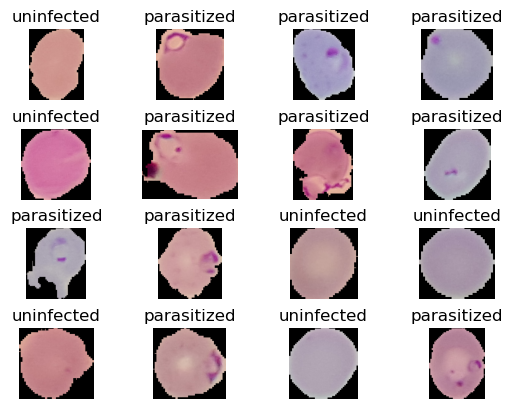

In [10]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis('off')

# Adjusting subplot parameters to add space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust these values as needed
plt.show()

# Data Preprocessing

## Data Augmentation

In [11]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [12]:
original_image, label = next(iter(train_dataset))

In [13]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor=0.3)

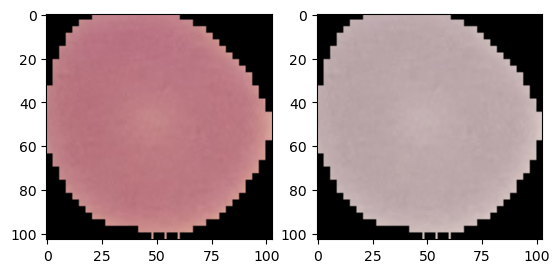

In [14]:
visualize(original_image, augmented_image)

In [15]:
IM_SIZE = 224

In [16]:
original_image, label = next(iter(train_dataset))

# tf.config.run_functions_eagerly(False)

@tf.function
def resize_rescale(image, label):
    # tf.print("I was here")
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [17]:
_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [18]:
### tf.keras.layer resizing and rescaling

resize_rescale_layers = tf.keras.Sequential()
resize_rescale_layers.add(Resizing(IM_SIZE, IM_SIZE))
resize_rescale_layers.add(Rescaling(1./255))

In [19]:
### tf.image augment

@tf.function
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)

In [20]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()
    
    @tf.function
    def call(self, image):
        return tf.image.rot90(image)

In [21]:
### tf.keras.layer augment

augment_layers = tf.keras.Sequential()
augment_layers.add(RandomRotation(factor=(0.25, 0.2501)))
augment_layers.add(RandomFlip(mode="horizontal"))
augment_layers.add(RandomContrast(factor=0.1))

@tf.function
def augment_layer(image, label):
    image = resize_rescale_layers(image)
    return augment_layers(image, training=True), label

## Data Loading

In [22]:
BATCH_SIZE = 32

In [23]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
train_dataset = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [25]:
val_dataset = val_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
val_dataset = val_dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [26]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
test_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# Mixup Data Augmentation

In [34]:
train_dataset_1 = train_dataset.shuffle(buffer_size=32).map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size=32).map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [35]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    image = lamda * image_1 + (1 - lamda) * image_2
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1 - lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

In [36]:
BATCH_SIZE = 32

train_dataset_mixed = mixed_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_mixed = train_dataset_mixed.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_mixed = train_dataset_mixed.batch(BATCH_SIZE)
train_dataset_mixed = train_dataset_mixed.prefetch(tf.data.AUTOTUNE)

tf.Tensor(
[9.2902809e-01 1.0000000e+00 1.2121010e-01 1.0000000e+00 0.0000000e+00
 1.7881393e-07 9.9968362e-01 9.3643785e-01 0.0000000e+00 9.9670386e-01
 1.0000000e+00 1.0000000e+00 2.6951534e-01 5.8834523e-02 0.0000000e+00
 9.9923098e-01 0.0000000e+00 9.9999231e-01 0.0000000e+00 1.0000000e+00
 9.9714136e-01 1.0000000e+00 8.4936619e-05 1.0000000e+00 1.0000000e+00
 3.4472644e-02 0.0000000e+00 3.6823219e-01 0.0000000e+00 6.0940136e-10
 1.0000000e+00 0.0000000e+00], shape=(32,), dtype=float32)
(32, 224, 224, 3)


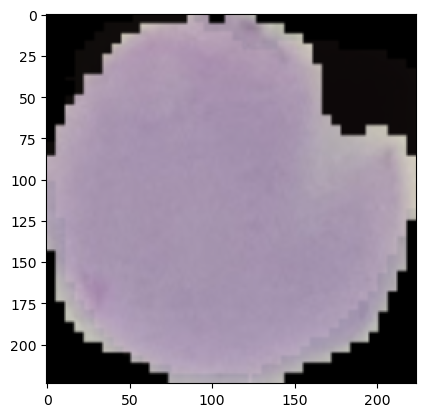

In [37]:
original_image, label = next(iter(train_dataset_mixed))
print(label)
print(original_image.shape)
plt.imshow(original_image[0])

# Cutmix Data Augmentation

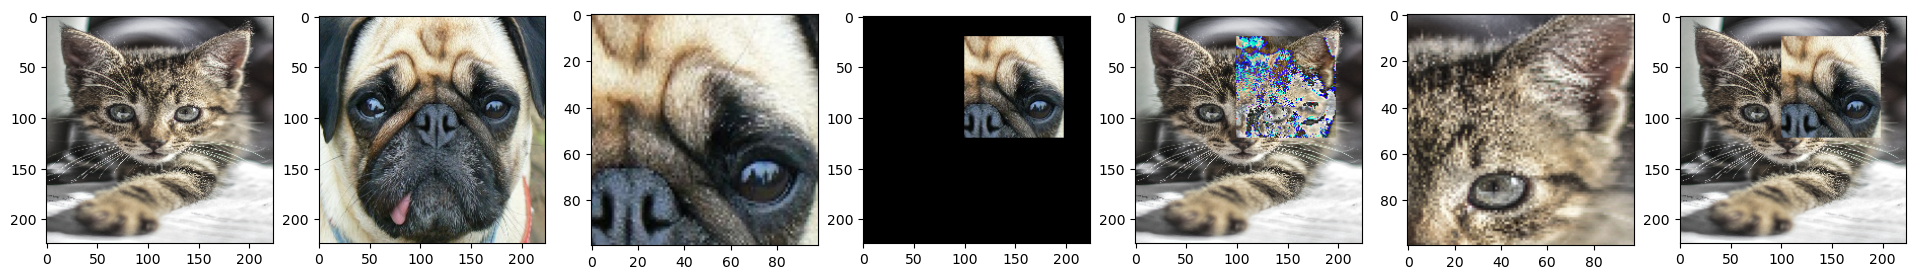

In [19]:
IM_SIZE = 224

plt.figure(figsize=(24, 12))

plt.subplot(1, 7, 1)

image_1 = cv2.resize(cv2.imread("images/cat.jpg"), (IM_SIZE, IM_SIZE))
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
plt.imshow(image_1)

plt.subplot(1, 7, 2)
image_2 = cv2.resize(cv2.imread("images/dog.jpg"), (IM_SIZE, IM_SIZE))
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
plt.imshow(image_2)

plt.subplot(1, 7, 3)
#                                   image, offset_height, offset_width, target_height, target_width
crop = tf.image.crop_to_bounding_box(image_2, 20, 100, 100, 98)
plt.imshow(crop)

plt.subplot(1, 7, 4)
image_4 = tf.image.pad_to_bounding_box(crop, 20, 100, IM_SIZE, IM_SIZE)
plt.imshow(image_4)

plt.subplot(1, 7, 5)
image_5 = image_1 + image_4
plt.imshow(image_5)

plt.subplot(1, 7, 6)
crop_cat = tf.image.crop_to_bounding_box(image_1, 20, 100, 100, 98)
plt.imshow(crop_cat)

plt.subplot(1, 7, 7)
image_6 = tf.image.pad_to_bounding_box(crop_cat, 20, 100, IM_SIZE, IM_SIZE)
plt.imshow(image_1 - image_6.numpy() + image_4)

In [20]:
r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)

lamda = tfp.distributions.Beta(0.2,0.2)
lamda = lamda.sample(1)[0]

r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

r_w = x_b_r - r_x
if (r_w == 0):
    r_w  = 1

r_h = y_b_r - r_y
if (r_h == 0):
    r_h = 1

r_y, r_x, r_h, r_w

(<tf.Tensor: shape=(), dtype=int32, numpy=87>,
 <tf.Tensor: shape=(), dtype=int32, numpy=35>,
 <tf.Tensor: shape=(), dtype=int32, numpy=36>,
 <tf.Tensor: shape=(), dtype=int32, numpy=36>)

In [21]:
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

    r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if (r_w == 0):
        r_w  = 1

    r_h = y_b_r - r_y
    if (r_h == 0):
        r_h = 1

    return r_y, r_x, r_h, r_w

In [26]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    
    r_y, r_x, r_h, r_w = box(lamda)
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

    image = image_1 - pad_1 + pad_2
    lamda = tf.cast(1- (r_w * r_h) / (IM_SIZE * IM_SIZE), dtype = tf.float32)
    label = lamda * tf.cast(label_1, dtype = tf.float32) + (1-lamda) * tf.cast(label_2, dtype = tf.float32)

    return image, label

In [23]:
train_dataset_1 = train_dataset.shuffle(buffer_size=32).map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size=32).map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [24]:
BATCH_SIZE = 32

train_dataset_mixed = mixed_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_mixed = train_dataset_mixed.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_mixed = train_dataset_mixed.batch(BATCH_SIZE)
train_dataset_mixed = train_dataset_mixed.prefetch(tf.data.AUTOTUNE)

Image shape: (32, 224, 224, 3)


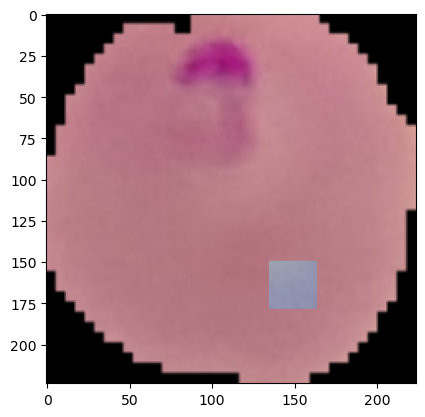

In [32]:
original_image, label = next(iter(train_dataset_mixed))

print("Image shape:", original_image.shape)

plt.imshow(original_image[0])

# Albumentations

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
!pip install -U albumentations

In [181]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    
    A.OneOf([A.HorizontalFlip(),
            A.VerticalFlip()], p=0.3),
    
    A.RandomRotate90(),
    # A.RandomGridShuffle(grid=(3,3), always_apply=False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                              contrast_limit=0.2,
                              always_apply=False, p=0.5),
    # A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=True, p=0.5),
])

In [182]:
def aug_albument(image):
    data = { "image": image }
    
    image = transforms(**data)
    image = image["image"]
    image = tf.cast(image/255., tf.float32)
    
    return image

In [183]:
def process_data(image, label):
    aug_image = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    
    return aug_image, label

In [184]:
BATCH_SIZE = 32

train_dataset_transformed = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_transformed = train_dataset_transformed.map(process_data)
train_dataset_transformed = train_dataset_transformed.batch(BATCH_SIZE)
train_dataset_transformed = train_dataset_transformed.prefetch(tf.data.AUTOTUNE)

In [185]:
train_dataset_transformed

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

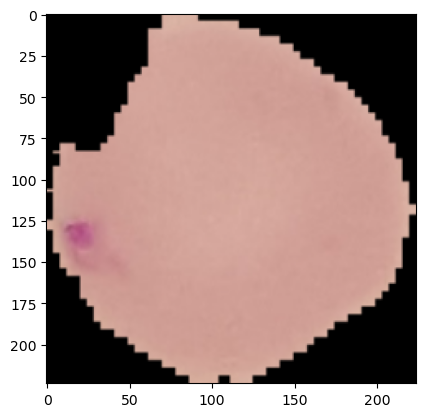

In [186]:
im, _ = next(iter(train_dataset_transformed))
plt.imshow(im[0])

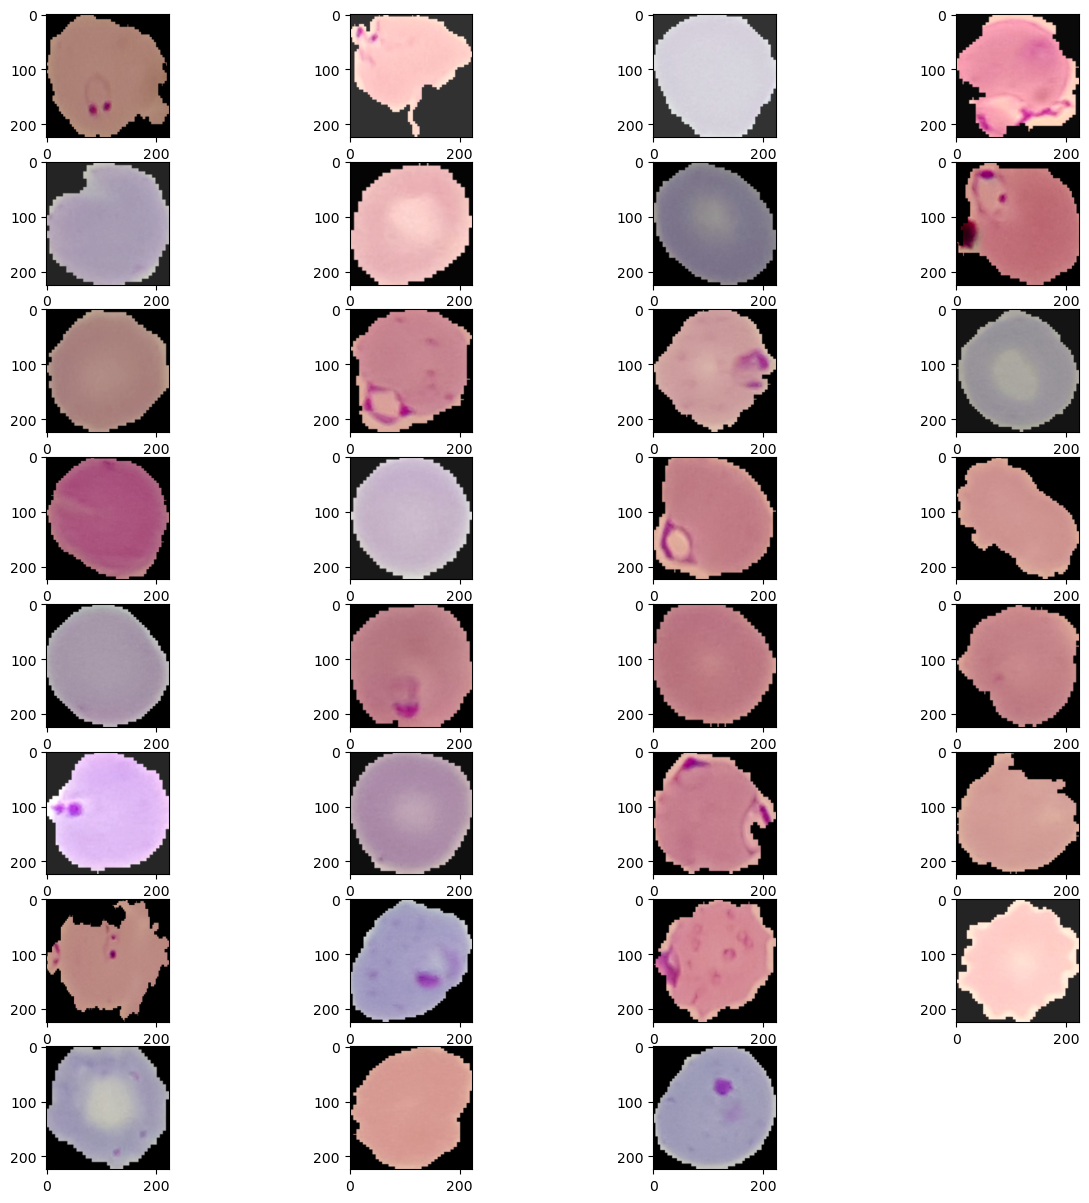

In [77]:
plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

# Repeating Dataset (x5)

In [46]:
def augment_1(image, label):
    image, label = resize_rescale(image, label)
    
    image = tf.image.random_brightness(image, 0.2)
    
    return image, label

In [47]:
def augment_2(image, label):
    image, label = resize_rescale(image, label)
    
    image = tf.image.random_flip_up_down(image)
    
    return image, label

In [48]:
def augment_3(image, label):
    image, label = resize_rescale(image, label)
    
    image = tf.image.flip_left_right(image)
    
    return image, label

In [49]:
def augment_4(image, label):
    image, label = resize_rescale(image, label)
    
    image = tf.image.rot90(image)
    
    return image, label

In [50]:
def augment_5(image, label):
    image, label = resize_rescale(image, label)
    
    return image, label

In [51]:
train_dataset_1 = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_1 = train_dataset_1.map(augment_1)

In [52]:
train_dataset_2 = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_2 = train_dataset_2.map(augment_2)

In [53]:
train_dataset_3 = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_3 = train_dataset_3.map(augment_3)

In [54]:
train_dataset_4 = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_4 = train_dataset_4.map(augment_4)

In [55]:
train_dataset_5 = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_5 = train_dataset_5.map(augment_5)

In [56]:
full_dataset = train_dataset_1.concatenate(train_dataset_2).concatenate(train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)

In [57]:
full_dataset

<ConcatenateDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [58]:
full_dataset = full_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
full_dataset = full_dataset.batch(BATCH_SIZE)
full_dataset = full_dataset.prefetch(tf.data.AUTOTUNE)

In [59]:
full_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# WanDB Dataset Versioning

## Data Loading

In [8]:
dataset, dataset_info = tfds.load(
    "malaria", 
    with_info=True,
    as_supervised=True, 
    shuffle_files=True, 
    split=["train"])

dataset

[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [69]:
if not os.path.exists('dataset'):
    os.makedirs('dataset')

k = 0
for image, label in dataset[0]:
    # Save image and label separately
    with open('dataset/malaria_dataset_image_' + str(k) + '.npz', mode='wb') as file:
        np.savez(file, image)
    with open('dataset/malaria_dataset_label_' + str(k) + '.npz', mode='wb') as file:
        np.savez(file, label)
        
    k += 1
    
    if (k % 1000 == 0):
        print(k)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [70]:
def load_original_data():
    with wandb.init(project="Malaria-Detection", entity="timothy-tandt") as run:
        
        original_state = wandb.Artifact(
            name="new_dataset",                          
            type="raw_data",
            description="The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
            metadata = {"source": "TFDS",
                        "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                        "source_code": "tfds.image_classification.Malaria",
                        "version": "1.0.0",
                        "download_size": "337.08 MiB"})
        
        original_state.add_dir('dataset/')
        
        run.log_artifact(original_state)
    

In [71]:
load_original_data()

wandb: Adding directory to artifact (.\dataset)... Done. 130.7s


## Data Preprocessing

In [9]:
with wandb.init("Malaria-Detection", entity="timothy-tandt") as run:
    artifact = run.use_artifact("timothy-tandt/Malaria-Detection/new_dataset:v0", type="raw_data")
    artifact_dir = artifact.download()

wandb: Downloading large artifact new_dataset:v0, 1420.33MB. 55117 files... 
wandb:   55117 of 55117 files downloaded.  
Done. 0:2:16.7


In [10]:
IM_SIZE = 224
def resize_rescale(image):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0

In [23]:
def preprocess_data():
    with wandb.init("Malaria-Detection",  entity="timothy-tandt") as run:
        
        artifact = run.use_artifact("timothy-tandt/Malaria-Detection/new_dataset:v0", type="raw_data")
        artifact_dir = artifact.download()
        
        preprocessed_data = wandb.Artifact(
            name="preprocessed_dataset",
            type="preprocessed_data",
            description="A preprocessed version of the Malaria dataset",
        )
        
        artifact_directory = "artifacts/new_dataset-v0/"
        
        dataset_x = []
        dataset_y = []
        
        image_files = [f for f in os.listdir(artifact_directory) if f.startswith("malaria_dataset_image")]
        
        for image_file in image_files[:1000]:
            label_file = image_file.replace("image", "label")
            
            with open(os.path.join(artifact_directory, image_file), 'rb') as image_file:
                image_npz = np.load(image_file, allow_pickle=True)
                image = image_npz
                
            with open(os.path.join(artifact_directory, label_file), 'rb') as label_file:
                label_npz = np.load(label_file, allow_pickle=True)
                label = label_npz
                
            dataset_x.append(image)
            dataset_y.append(label)
        
        # Convert lists to numpy arrays
        dataset_x = np.array(dataset_x)
        dataset_y = np.array(dataset_y)
        
        # Add data to preprocessed_data artifact
        preprocessed_data.add(dataset_x, "dataset_x")
        preprocessed_data.add(dataset_y, "dataset_y")
        
        
        with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
            np.savez(file, [dataset_x, dataset_y])
        
        # Save artifact
        run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

# Model Creation and Training

## Sequential API

In [28]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

In [29]:
lenet_model = tf.keras.Sequential()

lenet_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))
lenet_model.add(
    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding="valid", activation="relu",
           kernel_regularizer=L2(REGULARIZATION_RATE))
)
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2))

lenet_model.add(Dropout(rate=DROPOUT_RATE))

lenet_model.add(
    Conv2D(filters=(N_FILTERS * 2) + 4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding="valid", activation="relu", 
           kernel_regularizer=L2(REGULARIZATION_RATE))
)

lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2))

lenet_model.add(Flatten())

lenet_model.add(Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)))
lenet_model.add(BatchNormalization())
lenet_model.add(Dropout(rate=DROPOUT_RATE))

lenet_model.add(Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)))
lenet_model.add(BatchNormalization())

lenet_model.add(Dense(1, activation="sigmoid"))


lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)    

In [31]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=BinaryCrossentropy(), 
    metrics=metrics)

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

## Functional API

In [40]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)
x = BatchNormalization()(x)

output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_2 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_3 (Batc  (None, 109, 109, 16

In [42]:
feature_extractor_seq_model = tf.keras.Sequential()

feature_extractor_seq_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

feature_extractor_seq_model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
feature_extractor_seq_model.add(BatchNormalization())
feature_extractor_seq_model.add(MaxPool2D(pool_size=2, strides=2))

feature_extractor_seq_model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
feature_extractor_seq_model.add(BatchNormalization())
feature_extractor_seq_model.add(MaxPool2D(pool_size=2, strides=2))

feature_extractor_seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

## Callabable Model

In [43]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                       

## Model Subclassing

In [50]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)
        
        self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)
        
    def call(self, x, training):
        
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_1(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [51]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_2 (Featur  (None, 54, 54, 16)       1488      
 eExtractor)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_13 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                

In [55]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation="relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(10, activation="relu")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation="sigmoid")
        
    def call(self, x, training):
        
        x = self.feature_extractor(x)
        
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        
        x = self.dense_3(x)
        
        return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 244, 244, 3]))
lenet_sub_classed.summary()

Model: "lenet_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_6 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_14 (Dense)            multiple                  5569700   
                                                                 
 batch_normalization_29 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_30 (Bat  multiple               

## Custom Layers

In [58]:
class CustomDense(Layer):
    def __init__(self, output_units, activation):
        super(CustomDense, self).__init__()
        
        self.output_units = output_units
        self.activation = activation
        
        self.activation_functions = {
            "relu": tf.nn.relu,
            "sigmoid": tf.math.sigmoid
        }
        
    def build(self, input_features_shape):
        self.weight = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer="random_normal", trainable=True)
        self.bias = self.add_weight(shape=(self.output_units,), initializer="random_normal", trainable=True)
        
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.weight) + self.bias
        
        if self.activation in self.activation_functions:
            return self.activation_functions[self.activation](pre_output)
        
        return pre_output

In [59]:
IM_SIZE = 224

lenet_custom_model = tf.keras.Sequential()

lenet_custom_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

lenet_custom_model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_custom_model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_custom_model.add(CustomDense(100, activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(CustomDense(10, activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(CustomDense(1, activation="sigmoid"))

lenet_custom_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_31 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_32 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

# Callbacks

In [7]:
class LossCallback(Callback):
    def __init__(self):
        super(LossCallback, self).__init__()
        
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss {}".format(epoch + 1, logs["loss"]))
    
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch + 1, logs))

In [32]:
test_dataset = test_dataset.batch(1)

In [265]:
class LogImagesCallbackTensorBoard(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []
        
        for x, y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
            
        labels = np.array([i for i in labels])
        predicted = lenet_model.predict(np.array(inp))
        
        threshold = 0.5
        
        cm = tf.math.confusion_matrix(labels, predicted > threshold)
        
        plt.figure(figsize=(8, 8))
        
        sns.heatmap(cm, annot=True)
        plt.title("Confusion Matrix - {}".format(threshold))
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.axis("off")
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format="png")
        
        image = tf.image.decode_png(buffer.getvalue(), channels=3)
        image = tf.expand_dims(image, axis=0)
        
        CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
        IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)
        
        with image_writer.as_default():
            tf.summary.image("Training data", image, step = epoch)

## CSVLogger

In [53]:
csv_callback = CSVLogger("logs.csv", separator=",", append=True)

## EarlyStopping

In [54]:
es_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0,
    patience=2, 
    verbose=1, 
    mode="auto",
    baseline=None,
    restore_best_weights=False)

## Tensorboard

In [55]:
pip install -U tensorboard_plugin_profile

^C
Note: you may need to restart the kernel to use updated packages.


In [82]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [83]:
LOG_DIR = "./logs/" + CURRENT_TIME
tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1, profile_batch='100, 132')

## LearningRateScheduler

In [78]:
def scheduler(epoch, lr):
    
    if epoch <= 1:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
        
    with train_writer.as_default():
        tf.summary.scalar("Learning Rate", data=learning_rate, step=epoch)
    return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

## Model Checkpointing

In [72]:
checkpoint_callback = ModelCheckpoint(
    "weights.{epoch:02d}-{val_loss:.2f}.hdf5", 
    monitor="val_precision", 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode="auto",
    save_freq="epoch")

## ReduceLearningRateOnPlateau

In [74]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1,
    patience=5, 
    verbose=1)

# Custom Metric Class

In [49]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="Custom_Accuracy", FACTOR=1):
        super(CustomAccuracy, self).__init__()
        
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight = None):
        # print(y_true.dtype, y_pred.dtype)
        
        output = tf.keras.metrics.binary_accuracy(
            tf.cast(y_true, dtype = tf.float32), y_pred) * self.FACTOR
        
        # print(output)
        
        self.accuracy.assign(
            tf.math.count_nonzero(
                output, dtype = tf.float32) / tf.cast(len(output), dtype = tf.float32))

    def result(self):
        return self.accuracy

    def reset_state(self):
        self.accuracy.assign(0.)

# Custom Metric Method (without params)

In [50]:
def custom_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(y_true, y_pred)

# Custom Metric Method (with params)

In [51]:
def custom_accuracy(factor):
    def metric(y_true, y_pred):
        return tf.keras.metrics.binary_accuracy(y_true, y_pred) * factor
    return metric

# Custom Loss Class

In [52]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        
        self.FACTOR = FACTOR
        
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        
        return bce(y_true, y_pred) * self.FACTOR

In [53]:
def custom_bce(factor):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
    
        return bce(y_true, y_pred) * factor
    return loss

# Custom Training Loops

In [54]:
epochs = 3
factor = 1

metric = BinaryAccuracy()
metric_val = BinaryAccuracy()
optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE'])

In [55]:
@tf.function
def training_block(x_batch, y_batch):
    with tf.GradientTape() as recorder:
        y_pred = lenet_model(x_batch, training=True)
        loss = custom_bce(factor)(y_batch, y_pred)

    partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
    optimizer.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
    
    metric.update_state(y_batch, y_pred)
    
    return loss

In [34]:
@tf.function
def validation_block(x_batch, y_batch):
    y_pred_val = lenet_model(x_batch_val, training=True)
    loss_val = custom_bce(factor)(y_batch_val, y_pred_val)

    metric_val.update_state(y_batch_val, y_pred_val)
    
    return loss_val

In [38]:
def train(model, loss_function, metric, val_metric, optimizer, train_dataset, val_dataset, epochs):
    for epoch in range(epochs):
        print("Training starts for epoch number {}".format(epoch))

        for step, (x_batch, y_batch) in enumerate(train_dataset):
            loss = training_block(x_batch, y_batch)

        print("Training loss {}".format(loss))
        print("The accuracy is: {}".format(metric.result()))
        metric.reset_states()

        for (x_batch_val, y_batch_val) in val_dataset:
            loss_val = validation_block(x_batch_val, y_batch_val)

        print("Validation loss {}".format(loss_val))
        print("The val accuracy is: {}".format(metric_val.result()))
        metric_val.reset_states()

In [ ]:
train(lenet_model, custom_bce, metric, metric_val, optimizer, train_dataset, val_dataset, epochs)

# Training

In [56]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [70]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = BinaryCrossentropy(),
      metrics = metrics)

In [79]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 5,
    verbose = 1,
    # callbacks=[LogImagesCallbackTensorBoard()]
    callbacks=[tensorboard_callback, scheduler_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
689/689 [==============================] - 32s 46ms/step - loss: 0.0192 - tp: 10964.0000 - fp: 73.0000 - tn: 10948.0000 - fn: 61.0000 - accuracy: 0.9939 - precision: 0.9934 - recall: 0.9945 - auc: 0.9996 - val_loss: 0.3192 - val_tp: 1347.0000 - val_fp: 130.0000 - val_tn: 1228.0000 - val_fn: 50.0000 - val_accuracy: 0.9347 - val_precision: 0.9120 - val_recall: 0.9642 - val_auc: 0.9682 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5
689/689 [==============================] - 31s 45ms/step - loss: 0.0239 - tp: 10946.0000 - fp: 88.0000 - tn: 10932.0000 - fn: 80.0000 - accuracy: 0.9924 - precision: 0.9920 - recall: 0.9927 - auc: 0.9992 - val_loss: 0.2650 - val_tp: 1325.0000 - val_fp: 96.0000 - val_tn: 1267.0000 - val_fn: 67.0000 - val_accuracy: 0.9408 - val_precision: 0.9324 - val_recall: 0.9519 - val_auc: 0.9739 - lr: 0.0010

Epoch 3: LearningRateS

# Visualizations

In [73]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
LOG_DIR

'./logs/230324 - 175106'

In [ ]:
!tensorboard --logdir=LOG_DIR

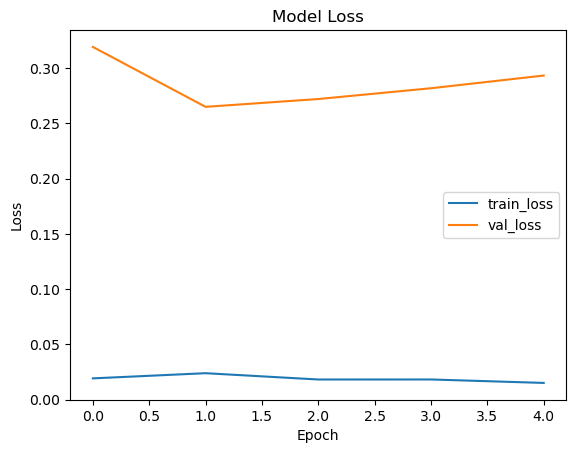

In [80]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

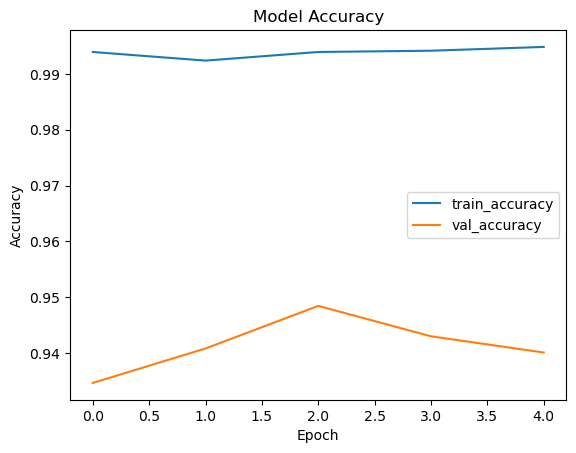

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation And Testing

In [85]:
test_dataset = test_dataset.batch(1)

In [86]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 18s 6ms/step - loss: 0.2518 - tp: 1292.0000 - fp: 93.0000 - tn: 1302.0000 - fn: 70.0000 - accuracy: 0.9409 - precision: 0.9329 - recall: 0.9486 - auc: 0.9743


[0.2518341541290283,
 1292.0,
 93.0,
 1302.0,
 70.0,
 0.9408777952194214,
 0.9328519701957703,
 0.9486050009727478,
 0.9742951989173889]

In [87]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [88]:
labels = np.array([i[0] for i in labels])
labels

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [89]:
predicted = lenet_model.predict(np.array(inp)[:,0,...])
predicted[:,0]

array([9.9879408e-01, 1.4937664e-06, 9.9999750e-01, ..., 9.9936193e-01,
       6.0234461e-06, 7.8866890e-07], dtype=float32)

[[1301   91]
 [  70 1295]]


Text(0.5, 58.7222222222222, 'Predicted')

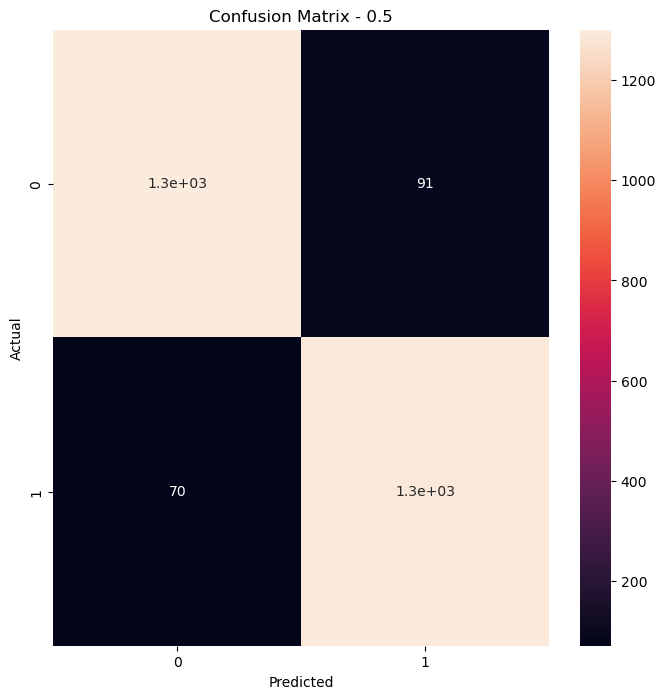

In [90]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix - {}".format(threshold))
plt.ylabel("Actual")
plt.xlabel("Predicted")

# TP, FP
# FN, TN

# ROC Plots

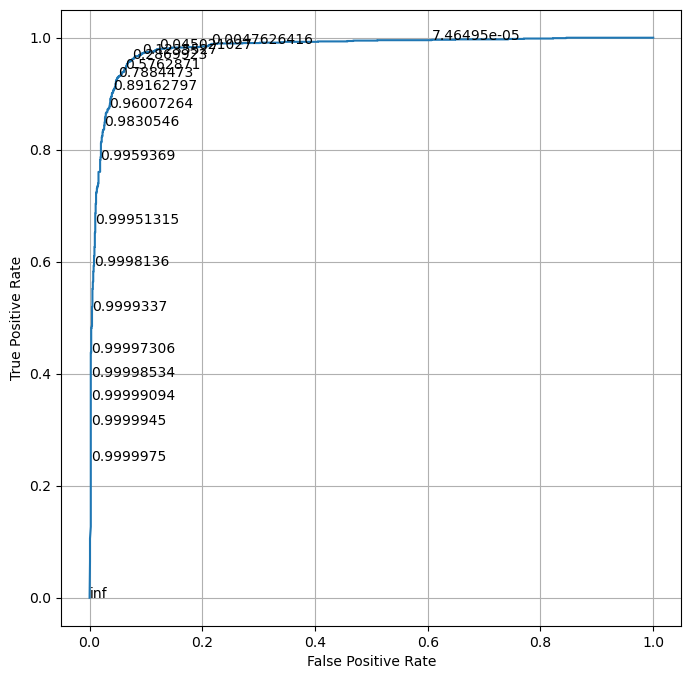

In [91]:
fp, tp, thresholds = roc_curve(labels, predicted)

plt.figure(figsize=(8,8))
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
    
plt.show()

In [92]:
def parasite_or_not(x):
    if x < 0.5:
        return "Parasitized"
    return "Uninfected"

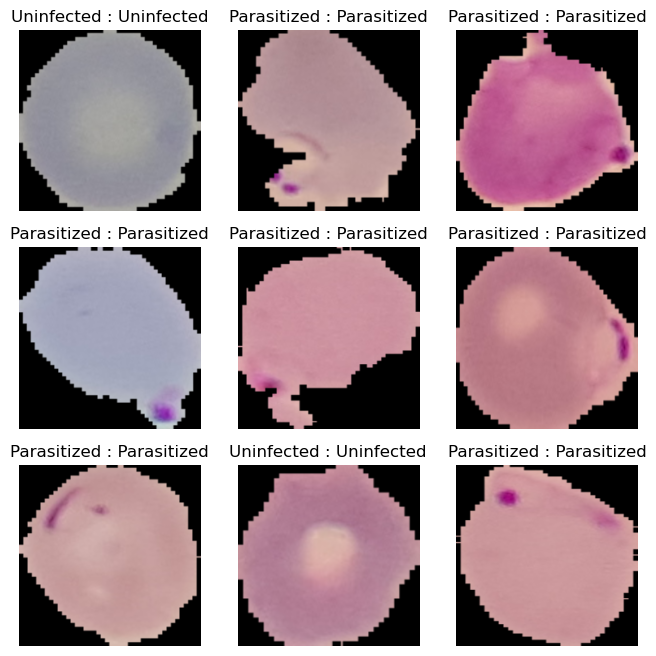

In [95]:
plt.figure(figsize=(8,8))

for i, (image, label) in enumerate(test_dataset.take(9)):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    
    title = f"{parasite_or_not(label.numpy()[0])} : {parasite_or_not(lenet_model.predict(image)[0][0])}"
    plt.title(title)
    
    plt.axis("off")
    
plt.show()